In [183]:
import pandas as pd
import numpy as np
import seaborn as sns

from more_itertools import batched

from matplotlib import pyplot as plt

from datetime import datetime, timedelta

from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import kpss, adfuller
from scipy.stats import boxcox

from tensorflow.keras import layers, losses, metrics, optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import AUC, Precision, Recall, F1Score

In [2]:
train = pd.DataFrame(pd.read_csv('data/dataset_lab3_train.csv')[['meantemp', 'date']])
test = pd.DataFrame(pd.read_csv('data/dataset_lab3_test.csv')[['meantemp', 'date']])

In [3]:
train.date = pd.to_datetime(train.date)
test.date = pd.to_datetime(test.date)

In [4]:
train.set_index('date', inplace=True)
test.set_index('date', inplace=True)

In [5]:
train = train.resample('ME').mean()
test = test.resample('ME').mean()

In [123]:
test

,meantemp
date,
2017-01-31,15.710873
2017-02-28,18.349981
2017-03-31,23.753760
2017-04-30,30.753663


In [9]:
def three_plot(data, figsize=(30, 10)):
    fig, axes = plt.subplots(3, 1)
    plt.rcParams.update({'figure.figsize': figsize, 'figure.dpi': 90})
    axes[0].plot(data)
    plot_acf(data, ax=axes[1])
    plot_pacf(data, ax=axes[2])
    plt.plot()


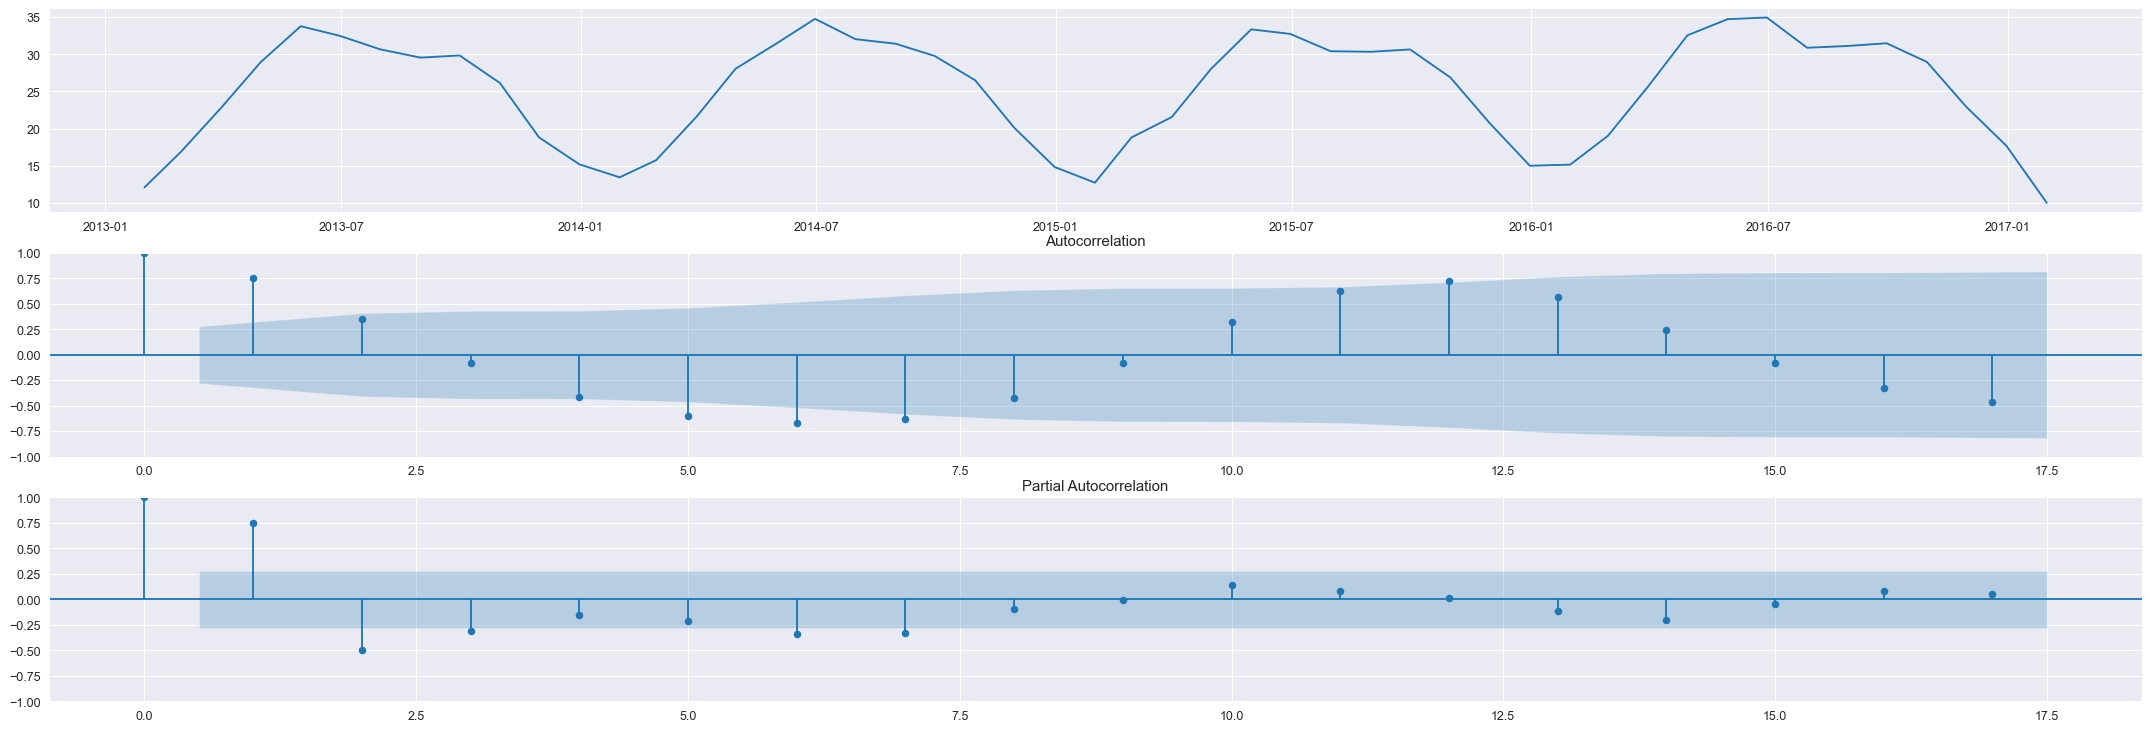

In [11]:
three_plot(train)

In [12]:
def stationary_test(data):
    p_value = adfuller(data)[1]
    is_stat = p_value > 0.05
    print(f'pvalue: {p_value} -> {"stationary" if is_stat else "non stationary"}')
    print(adfuller(data))
    return is_stat

pvalue: 0.8373097533459759 -> stationary
(-0.7356068926154032, 0.8373097533459759, 10, 25, {'1%': -3.7238633119999998, '5%': -2.98648896, '10%': -2.6328004}, 109.42769066021098)


True

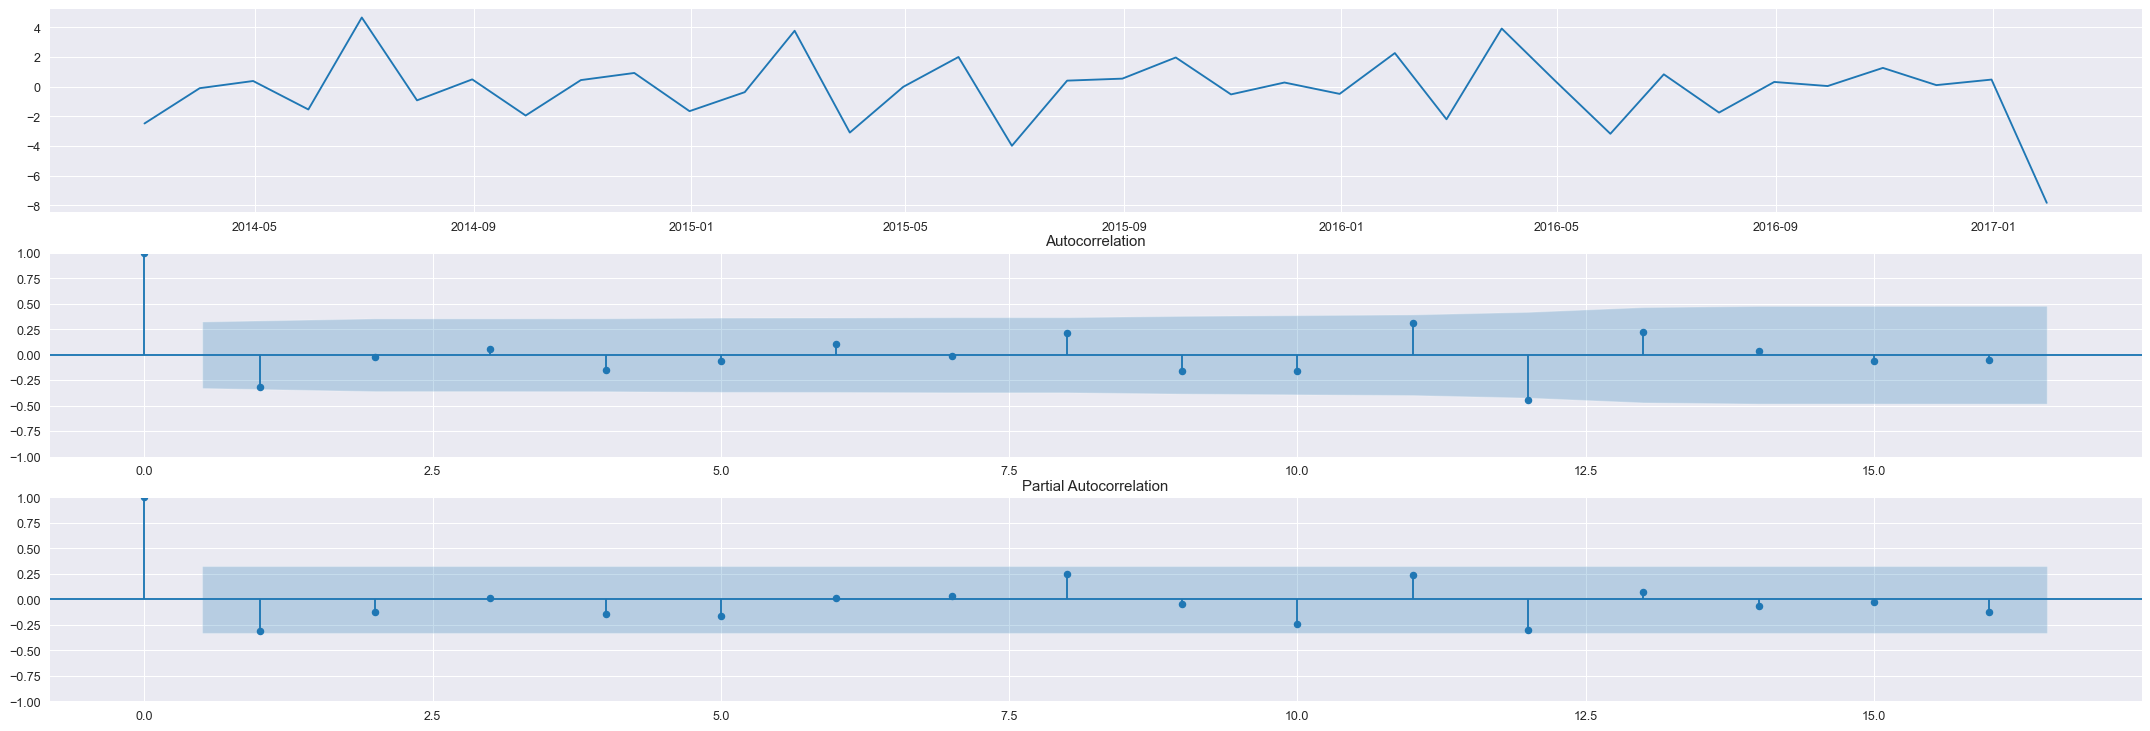

In [13]:
cox, _ = boxcox(train.meantemp)
cox = pd.DataFrame(cox)
diff_one = diff(train.meantemp, k_seasonal_diff=1, seasonal_periods=12)
three_plot(diff_one)
stationary_test(diff_one)
# print(f'pvalue: {p_value} -> {"stationary" if p_value < 0.05 else "non stationary"}')

In [14]:
arima = ARIMA(train, order=(7, 0, 7), seasonal_order=(0, 1, 1, 12)).fit()

D:\python\DataProcessingLabs\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\python\DataProcessingLabs\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\python\DataProcessingLabs\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
D:\python\DataProcessingLabs\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [15]:
preds = arima.predict(train.index[0], train.index[-1])
forecast = arima.forecast(10)

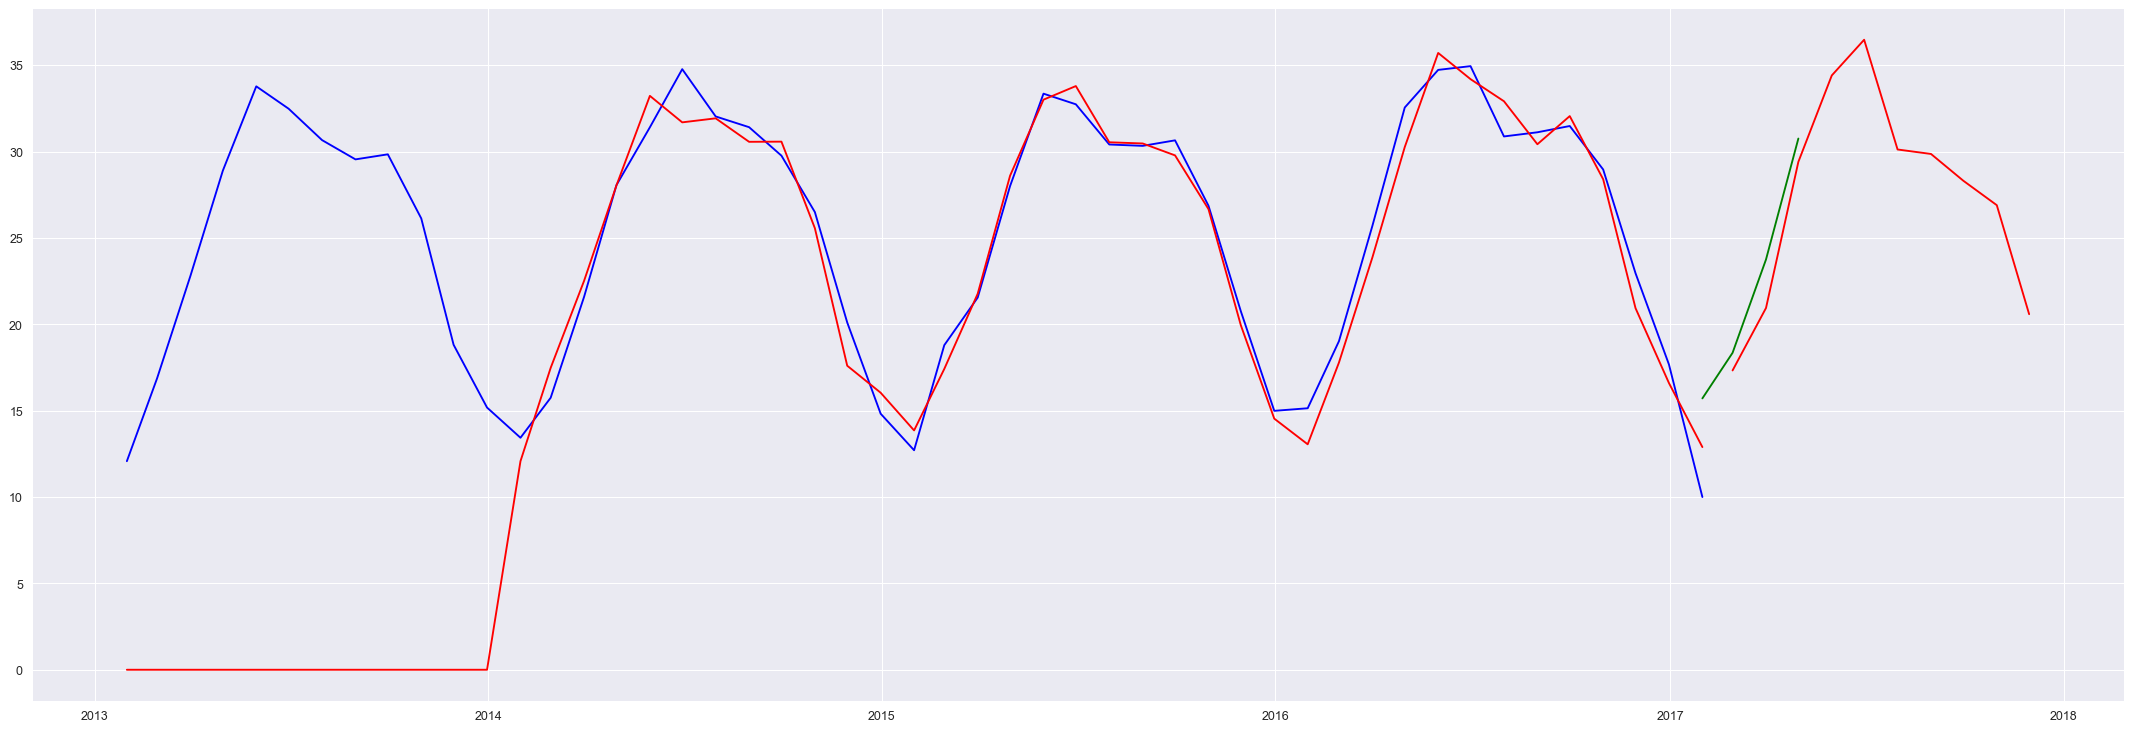

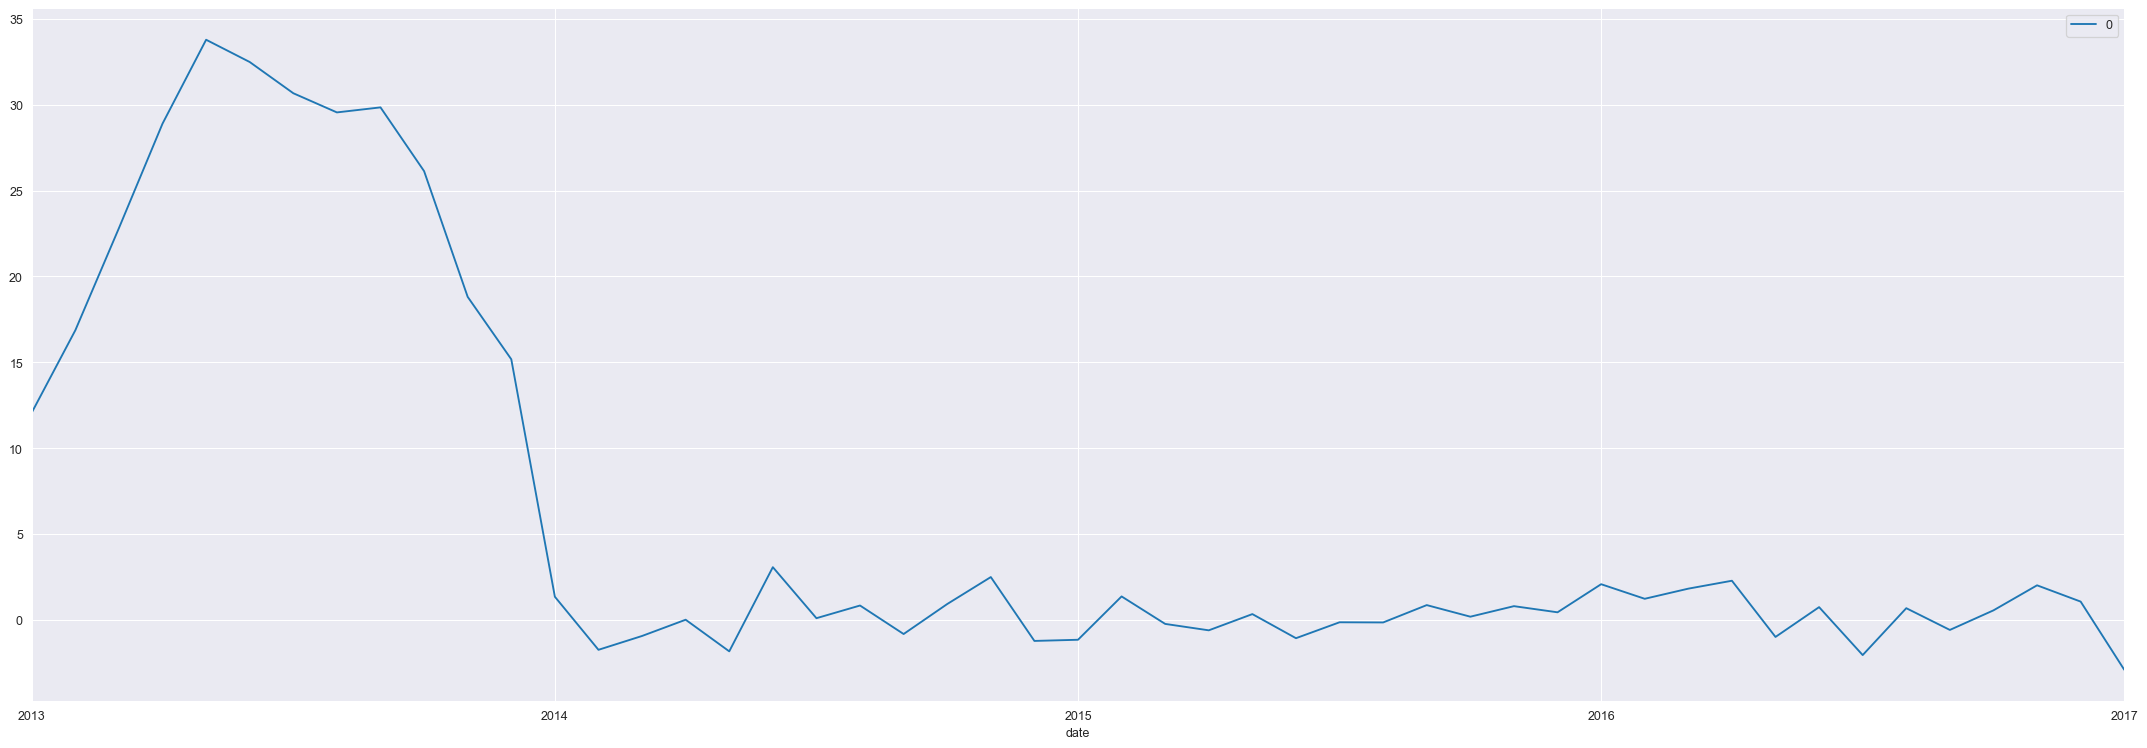

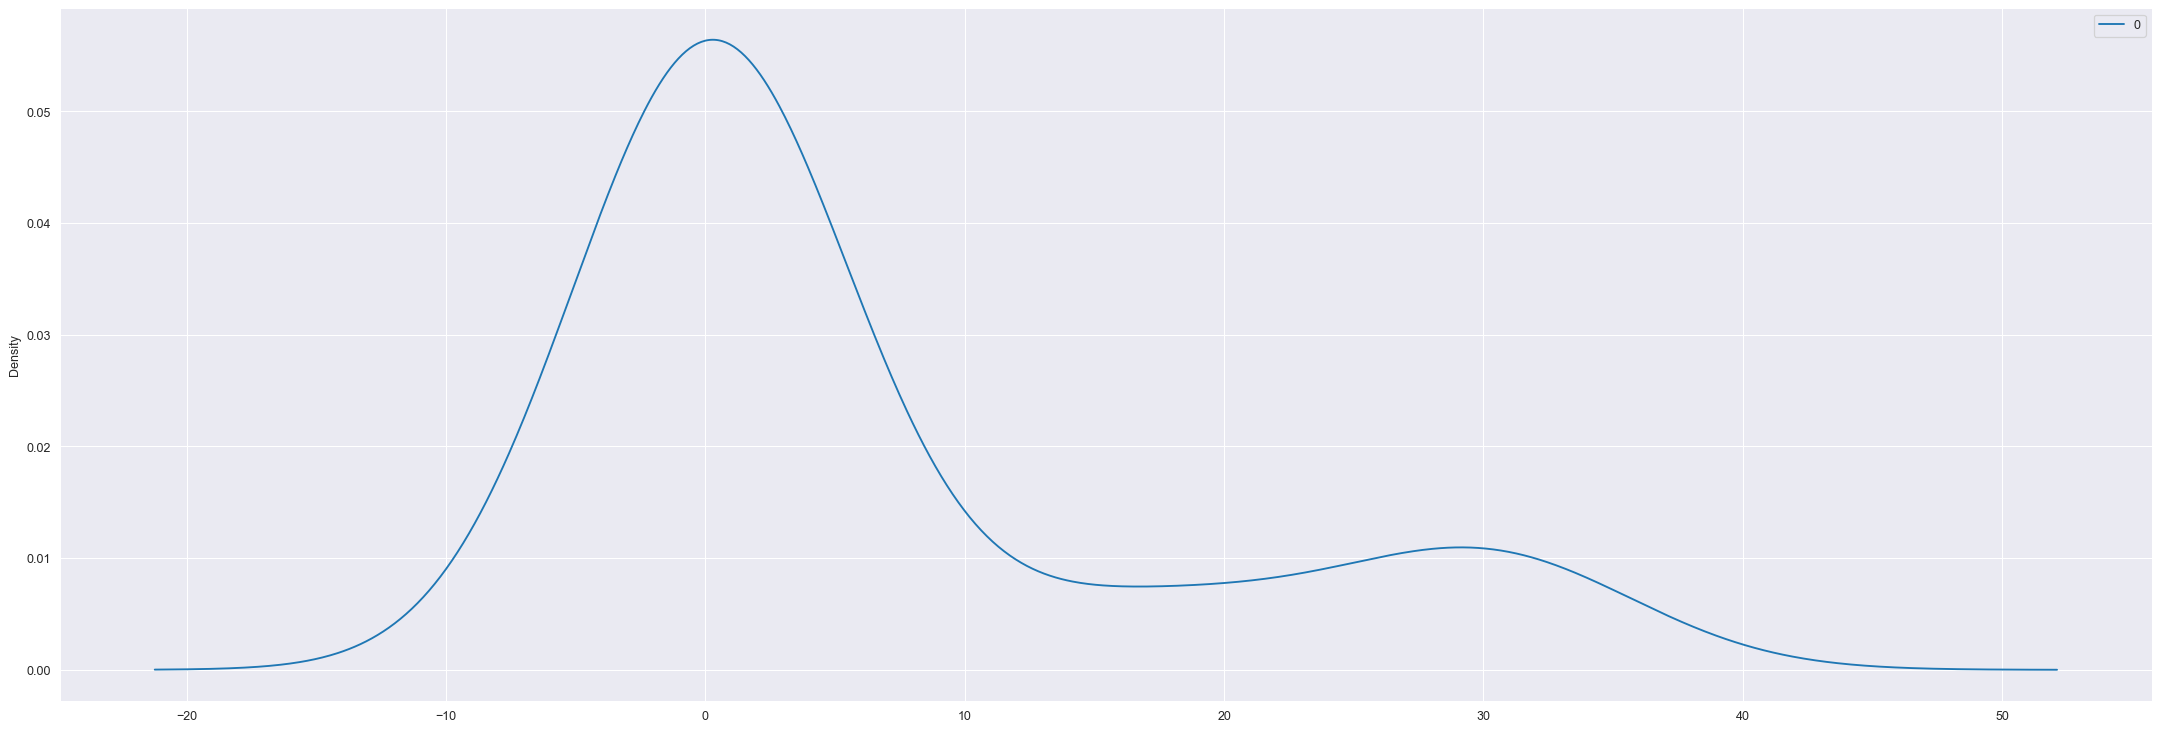

In [16]:
plt.plot(train, color='blue', label='Train')
plt.plot(test, color='green', label='Test')
plt.plot(preds, color='red', label='Preds')
plt.plot(forecast, color='red', label='Forecast')
plt.show()

# line plot of residuals
residuals = pd.DataFrame(arima.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()


In [298]:
X_train = train.reset_index().date.apply(datetime.timestamp).iloc[::-1].to_numpy()
X_test = test.reset_index().date.apply(datetime.timestamp).iloc[::-1].to_numpy()

y_train = train.meantemp.iloc[::-1].to_numpy()
y_test = test.meantemp.iloc[::-1].to_numpy()

In [299]:
def normalize(data):
    scaler = MinMaxScaler()
    series_matrix = data.reshape(len(data), 1)
    scaler.fit(series_matrix)
    return scaler.transform(series_matrix)

In [300]:
X_train = normalize(X_train)
X_test = normalize(X_test)

In [301]:
def my_batched(data: np.ndarray, batch_size: int, drop_tail=True):
    res = []
    for i in range(0, len(data) - batch_size + 1, batch_size):
        res.append(data[i:i + batch_size][::-1])
    if len(res[-1]) != batch_size and drop_tail:
        res = res[:-1]
    return res

batch_size = 4

X_train_batched = np.array(my_batched(X_train, batch_size))
X_test_batched = np.array(my_batched(X_test, batch_size))

X_train_batched = X_train_batched.reshape(X_train_batched.shape[0], X_train_batched.shape[1], 1)
X_test_batched = X_test_batched.reshape(X_test_batched.shape[0], X_test_batched.shape[1], 1)

y_train_batched = y_train[::-4]
y_test_batched = y_test[::-4]

# y_train_batched = np.array(my_batched(y_train, batch_size))
# y_test_batched = np.array(my_batched(y_train, batch_size))
# 
# y_train_batched = y_train_batched.reshape(y_train_batched.shape[0], y_train_batched.shape[1], 1)
# X_test_batched = X_test_batched.reshape(X_test_batched.shape[0], X_test_batched.shape[1], 1)

In [270]:
X_test_batched

array([[[0.        ],
        [0.31460674],
        [0.66292135],
        [1.        ]]])

train

In [302]:
lstm = Sequential([
    layers.Input(shape=(4, 1)),
    layers.LSTM(units=32, activation='relu'),
    layers.Dense(1)
])

lstm.compile(loss='mean_squared_error',
             optimizer=optimizers.Adam(), metrics=['accuracy'])

lstm.fit(X_train, y_train, epochs=20, validation_split=0.1)



Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step - accuracy: 0.0000e+00 - loss: 693.6121 - val_accuracy: 0.0000e+00 - val_loss: 585.0593
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0000e+00 - loss: 703.1547 - val_accuracy: 0.0000e+00 - val_loss: 584.9025
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0000e+00 - loss: 702.2122 - val_accuracy: 0.0000e+00 - val_loss: 584.7471
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0000e+00 - loss: 685.0701 - val_accuracy: 0.0000e+00 - val_loss: 584.5931
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.0000e+00 - loss: 697.1881 - val_accuracy: 0.0000e+00 - val_loss: 584.4386
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0000e+00 - loss: 685.7346 - val_accuracy: 0.0000e+00 - val_loss: 584.2828
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0000e+00 - loss: 708.5693 - val_accuracy: 0.0000e+00 - val_loss: 584.1262
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3

In [304]:
# lstm.evaluate(test_batched_date, test)
print(y_test_batched)
np.reshape(lstm.predict(X_test_batched))


[15.71087258]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([[0.27795708]], dtype=float32)